# Простые методы предсказания ВР

## Библиотека  SKTIME

Библиотеки [<b>aeon<b>](https://www.aeon-toolkit.org/) и [<b>Scikit-Time</b> (<b><code>Sktime</code></b> )](https://www.sktime.net/en/stable/) — это набор инструментов Python с [открытым исходным кодом](https://github.com/alan-turing-institute/sktime) для работы временными рядами. В основном библиотеки предполагает использование методов машинного обучения. 
Библиотеки расширяет `API scikit-learn` (а также некоторых [других библиотек](https://wandb.ai/site/articles/a-gentle-introduction-to-time-series-analysis-forecasting)) для задач временных рядов. Он предоставляет необходимые алгоритмы и инструменты преобразования для эффективного решения задач регрессии, прогнозирования и классификации. Библиотека включает специальные алгоритмы обучения временных рядов и методы преобразования. 
    
Отметим, что оригинальная статья по данным фреймворкам может быть найден [тут](https://arxiv.org/pdf/2005.08067.pdf). Также ряд фреймровко предлагают сравнение их функционала с конкурентами. Другими словами некторый обзор фрейморков. Такой обзор может быть найден, например, [тут](https://github.com/salesforce/Merlion?tab=readme-ov-file#comparison-with-related-libraries).

Если у вас не установленна данная библиотека, давайте установим ее при помощи следующего кода. Рекомендации по установке можно найти в официальной документации [тут](https://www.sktime.net/en/stable/installation.html). 

Отметим, что хоть мы и указываем тут код для установки компонент `sktime`, в общем случае рекомендуем установить полную версию пакета с использованием командной строки. Например, для этого можно использовать следующий скрипт
```python
pip install --upgrade sktime[all_extras]
```

In [1]:
# try:
#     import sktime
# except:
# #     !pip install sktime --user
# #     !pip install pmdarima
# #     !pip install statsmodels
# #     !pip install prophet
#     !pip install --upgrade sktime[all_extras]
# import aeon

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", FutureWarning)

In [3]:
import sktime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.compose import  TransformedTargetForecaster, AutoEnsembleForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster, TrendForecaster, STLForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.bats  import BATS
from sktime.forecasting.ets   import AutoETS

from sktime.forecasting.statsforecast import (StatsForecastAutoETS, 
                                              StatsForecastAutoTheta,
                                              StatsForecastAutoCES,
                                              StatsForecastMSTL)

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

from sktime.utils.plotting import plot_series
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

В качестве набора данных давайте загрузим рассмотренный ранее набор данных о потреблении электричества в Германии. 

In [6]:
path_ts = 'de_data.csv'
df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
df=df.fillna(df.mean())
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01,1088.317,325.165,103.386051,371.25795
2015-01-02,1246.588,603.554,7.757000,611.31100
2015-01-03,1117.554,462.955,7.237000,470.19200
2015-01-04,1081.980,385.023,19.982000,405.00500
2015-01-05,1325.920,216.540,26.522000,243.06200


В первую очередь в данном уроке мы будем рассматривать однопеременные методы (`univariate time series`). Поэтому выберем один из столбцов данных в качестве отдельного временного ряда. 

Кроме того, в ходе предыдущего анализа было установлено, что ряд имеет как минимум 2 составляющие (быструю, с периодом неделя и медленную с периодом 1 год). Для упрощения анализа и без значительных потерь значимости удалим быструю составляющую при помощи перегруппировки данных.

In [7]:
y = df.Consumption.asfreq('7d')
# y.index = pd.PeriodIndex(y.index) # pd.to_datetime(y.index)
y.head()

Date
2015-01-01    1088.317
2015-01-08    1474.375
2015-01-15    1479.245
2015-01-22    1496.905
2015-01-29    1508.443
Freq: 7D, Name: Consumption, dtype: float64

In [8]:
# В качестве альтернативы можно бы было использовать resample('7d'), 
# но в этом случае пришлось бы дополнительно использовать следующую функцию.
# def add_freq(idx, freq=None):
#     """Add a frequency attribute to idx, through inference or directly.
#     Returns a copy.  If `freq` is None, it is inferred.
#     """
#     idx = idx.copy()
#     if freq is None:
#         if idx.freq is None:
#             freq = pd.infer_freq(idx)
#         else:
#             return idx
#     idx.freq = pd.tseries.frequencies.to_offset(freq)
#     if idx.freq is None:
#         raise AttributeError('no discernible frequency found to `idx`.  Specify'
#                              ' a frequency string with `freq`.')
#     return idx
# y = df.Consumption.resample('7d').sum()[1:-2]
# y.index = add_freq(y.index)

Проведем визуализацию полученных данных при помощи встроенных утилит.

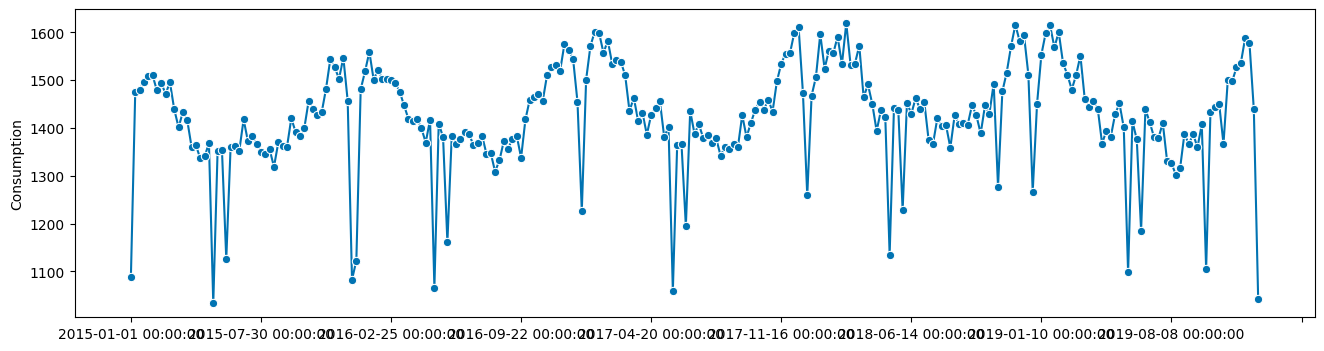

In [9]:
plot_series(y);

Для разделения данных воспользуемся функцией `temporal_train_test_split`, которая позволяет адаптировать разделение данных не разрушая временные зависимости в данных. Отметим, что данная функция не единственный тип разделения данных. Более подробную информацию можно найти [тут](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=24f6be86f95bfc1ec246dee7dcdd455e0a84a872&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c616e2d747572696e672d696e737469747574652f736b74696d652f323466366265383666393562666331656332343664656537646364643435356530613834613837322f6578616d706c65732f77696e646f775f73706c6974746572732e6970796e62&logged_in=false&nwo=alan-turing-institute%2Fsktime&path=examples%2Fwindow_splitters.ipynb&platform=android&repository_id=156401841&repository_type=Repository&version=98).

In [ ]:
TEST_SIZE = int(0.45*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

plot_series(y_train, y_test, labels=["y_train", "y_test"]);

В целом задача предсказания значений ВР представляет собой [обширный перечень методов](https://neerc.ifmo.ru/wiki/index.php?title=Анализ_временных_рядов). Методы могут быть разделены на различные таксономии. В том числе по тому, какие задачи могут быть решены, или [наприммер](https://www.sas.com/content/dam/SAS/en_ca/User%20Group%20Presentations/Edmonton-User-Group/NateDerby-TimeSeriesForecastingNovember2009.pdf), по уровню соответствующего статистического подхода.

<img src="https://i.pinimg.com/736x/4b/79/b7/4b79b73b6b7bef191a9e582d387a39f0.jpg" width="900px">

или например

<img src="https://www.researchgate.net/publication/358080275/figure/fig2/AS:1120768494698499@1644223440381/Classification-of-time-series-forecasting-methods-and-models.png" width="900px">

В этом занятии мы рассмотрим только самые простые подходы к решению задачи предсказания. В том числе:
* [наивные методы](https://otexts.com/fpp3/simple-methods.html) предсказания - когда следущие значения в каком виде повторояют одно из предыдущих.
* методы на основе [скользящего/экспоненциального сглаживания](https://otexts.com/fpp3/expsmooth.html) - когда следующие значения являются результатам некоторой фильтрации набора предыдущих значений (обработки ВР окном или окнами с весовыми параметрами).
* методы на основе [регрессии](https://otexts.com/fpp3/regression.html) - в которых предлагается некоторя модель детерминированного ВР на фоне шумов и некоторое решение для оценки параметров этой модели. Модели могут быть как линейные, так и [нелинейные](https://otexts.com/fpp3/advanced.html).

## Наивные методы предсказания

Помимо разделения данных на тренированные и тестовые предсказание в `sktime` может потребовать т.н. `forecasting horizon` - то есть непосредственного указания числа предсказываемых значений. Такой горизонт предсказания можно задавать по разному, при помощи массива или объекта класса `ForecastingHorizon`. Последний способ предоставляет более развитый инструментарий.

В рамках данного занятия мы рассмотрим наиболее [простые алгоритмы предсказания](https://forecasting-encyclopedia.com/theory.html#introduction_to_the_theory_of_forecasting), которые условно разделим на:
* **Наивные методы предсказания** [(`NaiveForecasters`)](https://otexts.com/fpp3/simple-methods.html), позволяющие оценивть будущие значения как некоторые простые преобразования имеющихся значений ВР.
* **Подход на основе моделей экспоненциального сглаживания** [Exponential smoothing](https://otexts.com/fpp3/taxonomy.html) и [модфикаций подхода](https://openforecast.org/adam/exponential-smoothing.html).
* **Методы с использованием** [регрессионных подходов](https://otexts.com/fpp3/regression.html) как простых, так и [современных](https://otexts.com/fpp3/prophet.html).

Для начала давайте попробуем выполнить наивное предсказание. То есть каждое следующее предсказанное значение будет лишь копией предыдущего, начиная с последнего значение тренировочной выборки.

Мы полагаем, что проблемы данного предсказания очевидны, однако, давайте все же [проверим ошибку](https://otexts.com/fpp3/accuracy.html). Для этого воспользуемся [симметричной средней процентной ошибкой](https://mlpills.dev/time-series/error-metrics-for-time-series-forecasting/) (<b>symmetry Mean Average Percentage Error, [sMAPE](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsolutePercentageError.html)</b>) 
    $$ sMAPE =2\frac{1}{H}\sum_{i=1}^{H} \frac{|y(h_i) − \hat{y}(h_i)|}{|y(h_i)| + |\hat{y}(h_i)|}
 $$
    
    


In [ ]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Также давайте попробуем оценить точность наивного сезонного предсказания. В данном случае указана статегия `strategy="mean"` это означает что значения будут выбраны как средние. Это могут быть средние значения по всей тренировочной выборке или по заданному окну размера `window_length`. В данном случае окно не указано, поэтому в качестве его длины выбрана вся длина ВР.

In [ ]:
SEASON = 52

forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Отметим, что список всех доступных методов оценки может быть найден в следующем виде

In [ ]:
# all_estimators("forecaster", as_dataframe=True)

## Методы экспоненциального сглаживания

Одними из наиболее простых методов являются семейство методов на основе экспоненциального сглаживания   (`Exponential Smoothing`, `Holt-Winter` и другие). Давайте посмотрим на их работу. Для начала оценим точность наиболее простого варианта `Simple Exponential Smoothing`.

Напомним, что простое экспоненциальное сглажевание выполняет тот же расчет взвешенного скользящего среднего (метод pandas <tt>.ewm()</tt>):<br>
$\begin{align}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{align}$

<!-- <div class="alert alert-info"><h4>Связанные функции:</h4>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong ><font color=green>(конец)</font>&nbsp;&nbsp;&nbsp;&nbsp; -->

In [ ]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Попробуем теперь другие варианты

In [ ]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)



forecaster = holt_winter

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')


Точность в предыдущих случаях оставляла желать лучшего. Однако, теперь давайте посмотрим на возможность ансамблирования таких методов

In [ ]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
forecaster = AutoEnsembleForecaster(
    [
#         ("ses", ses),
#         ("holt", holt),
#         ("damped", damped_holt),
        ("holt-winter",holt_winter),
#         ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
#         ("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
#         ("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)        
    ]
)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]); 



В общем случае пакет `sktime` позволяет использовать автоматизированный подбор параметров модели экспоненциального сглаживания. Для этого может быть использован пакет `AutoETS`. Модель, реализуемая данным пакетом также называется `Error-Trend-Season (ETS)`. В случае необходимости исследователь может вручную задать параметры модели, в формате `ETS(X,X,X)s`</b>, где `X` может быть <tt>N-None, A-additive, M-multiplicative, Ad-additive dumped</tt>, `s`-период сезона или `None`. 

Частными примерами модели `ETS` являются:
* Simple Exponential smoothing `ETS(A,N,N)`.  
* Triple Exponential smoothing `ETS(A,A,A)`. 
* и многие другие.
> Отметим, что <tt>Exponential smoothing</tt> использует эвристические значения для начальных состояний, а затем оценивает параметры сглаживания, оптимизируя функцию потерь `MSE`. В тоже время `ETS()` оценивает и начальные состояния, и параметры сглаживания, оптимизируя функцию максимального правдоподобия (`NNL`) (что эквивалентно оптимизации MSE только для линейных аддитивных моделей). \
> В ряде случаев можно также рассматривать и другие модели на основе экспоненциального сглаживания, например [с регрессией](https://orbit-ml.readthedocs.io/en/stable/tutorials/dlt.html) или с разделением [глобального и т.н. локального тренда](https://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html).

In [ ]:
forecaster = AutoETS(auto=True, sp=SEASON, n_jobs=-1)

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Отметим, что аналогично может быть использован подход [`StatsForecastAutoETS`](https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoets.html). Особенностью данного подхода является автовыбор не только коэффициентов моделей, но и их конфигураций. Для этого искомые конфигурации помечаются индексом `Z`.

In [ ]:
forecaster = StatsForecastAutoETS(season_length = 52,
                                  model = 'ZZA',
                                  damped = True,)

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Другим методом оценки данных с вилянием сезонности и тренда является использование предварительной декомпозиции  временного ряда. Одним из наиболее простых методов декомпозиции является разделение на тренд, сезонность и остаток.  Давайте посмотрим на то, как будут выглядеть результаты такого разложения.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train, model='additive', period = 52)
result.plot();

В рамках пакета `SKTime` разложение можно выполнить при помощи объектов класса `Deseasonalizer` и `Detrender`. Давай для начала посмотрим отдельно на их работу

In [ ]:
deseason = Deseasonalizer(model="additive", sp=52) #Remove seasonal components from a time series.
detrend  = Detrender(forecaster=TrendForecaster())

season   = y_train.values.squeeze() - deseason.fit_transform(y_train.values).squeeze()
trend    = y_train.values.squeeze() - detrend.fit_transform(y_train.values).squeeze()
residual = y_train.values.squeeze() - trend - season

plt.plot(season, c='k', label='season')
plt.plot(trend, c='g', label='trend')
plt.plot(residual, c='r', label='residual')
plt.plot(y_train.values, c='b', label='original data')
plt.legend()
plt.show()

Для каждой из указанных частей  (трнед и сезонность) можно бы было построить по отдельному прогнозу, которые затем бы были просуммированы (аддитивная модель). Более того сезонных составляющих может быть несколько.
На практике для такого разложения проще использовать контейнер `TransformedTargetForecaster` - который является некоторым аналогом пайплайна.

## Методы с использованием регрессии

In [ ]:
SEASON = 52

fh = ForecastingHorizon(y_test.index, is_relative=False)

# объек предсказатель
ses         = ExponentialSmoothing()

# пайплайн
forecaster = TransformedTargetForecaster(
                steps=[
                ("deseasonalize", Deseasonalizer(model="additive", sp=SEASON)),
                ("detrend", Detrender(forecaster=TrendForecaster())),
                ("forecaster", ses)
                ])
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)

# Результаты
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

>Отметим, что в наиболее простом случае разложить ВР $y(t)$ на составляющие можно бы было следующим алгоритмом 
>* Вычислить тренда $T(t)$, например методом скользящего среднего с длинным окном.
>* Вычислить функционала вида  $y(t)-T(t)$ (`Detrend`).
>* Вычислить основную сезонную составляющую $S(t)$ путем усреднение знечений с шагом сезонности `s`. Например, для месячных данных сезонный компонент для марта представляет собой среднее значение всех мартовских значений в данных без тренда. Этот шаг можно бы было проделать для каждого значения сезонности.  
>* Создать ряд сезонностей $S(t)$ заданной длительности.
>* Вычислить остаток разложения $R(t) =y(t)-T(t)-S(t)$
>
>Однако, такое разложение было бы не стабильным к нестационарностям,  редким событиям (в т.ч. аномалиям и регулярным событиям) и сложному виду тренда.
<!-- https://medium.com/analytics-vidhya/time-series-forecasting-using-tbats-model-ce8c429442a9
https://otexts.com/fpp2/classical-decomposition.html
https://www.openforecast.org/adam/classical-seasonal-decomposition.html
http://www.gardner.fyi/blog/STL-Part-II/ -->




В общем случае пакет [`sktime`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.trend.STLForecaster.html) включает ряд методов, использующих разлжение ВР в целях предсказания. Одним из наиболее популярных среди таковых является использование `STL` (<tt>Seasonal-Trend decomposition using LOESS </tt>) предсказания. Метод позволяет разложить ВР устойчиво к типичным выбросам и редким событиям. 
Метод заключается в использовании двух циклов:
* внутренний цикл:
    * вычисляется приблизительный тренд, например как линейная аппроксимация данных.
    * вычисляются сезонные составляющие путем усреднения с заданынм сезоном.
    * Далее вычисляется оконечный вид тренд из данных без сезонной части. Вычисление производится путем локальной взвешенной регрессии <tt>LOESS</tt>.
    * вычисляется остаток разолжения.
* внешний цикл минимизирует влияние выбросов в остатке разложения. 

Метод может быть напрямую использован для предсказаний. Метод реализован в `sktime` в двух вариантах, один из которых относится к классической библиотеке [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html), а второй к новой и перспективной библиотеке [nixtla](https://nixtlaverse.nixtla.io/statsforecast/docs/models/multipleseasonaltrend.html). Мы используем только второй вариант.  Отметим, что в данном варианте также заложена возможность для аппроксимации нескольких сезонных компонент.

Также отметим, что после аппроксимации разложения предсказатель для тренда [может быть заменен на другой](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html).

<!-- https://machinelearningmastery.ru/stl-decomposition-how-to-do-it-from-scratch-b686711986ec/
 https://github.com/bdemeshev/ts_pset/raw/master/ts_pset_main.pdf
http://statmod.ru/wiki/_media/study:spring2020:ts:notes20200406.pdf
https://ru.wikibrief.org/wiki/Local_regression -->


In [ ]:
forecaster = StatsForecastMSTL(season_length=52,)  
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

`ThetaForecaster` - метод предсказания временных рядов на основе экспоненциального сглаживания для модели с дрейфом тренда (случайный тренд). Модель дополнительно включает парамерт сезонности. Другими словами модель игнорирует  эффект сезонности при построении модели прогноза.  Более подробон можно ознакомится с модель в пакете [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/theta-model.html). Модель включает следующие шаги:
1. Устранение сезонности (`Deseasonalize`) если та определена. 
2. Построение двух линейных моделей прогноза - модель линейной регресии и модель простого скользящего среднего.
3. Объеденение двух моделей. Отметим, что в оригинальной идеи моделей может быть и больше двух.
4. Восстоновление сезонной составляющей.

In [ ]:
forecaster = ThetaForecaster(sp=SEASON)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

В последних версиях пакета `sktime` также предлагается и альтернативная реализация метода [`StatsForecastAutoTheta`](https://nixtla.github.io/statsforecast/models.html#autotheta) эта версия реализована в новом и очень перспективном пакете [`statsforecast`](https://github.com/Nixtla/statsforecast) от компании [nixtla](https://www.nixtla.io/). [Особенностью данной реализации](https://nixtlaverse.nixtla.io/statsforecast/docs/models/autotheta.html) является поиск среди нескольких вариантов моделей данного семейства, в том числе:  <tt>Standard Theta Model (`STM`), Optimized Theta Model (`OTM`), Dynamic Standard Theta Model (`DSTM`), Dynamic Optimized Theta Model (`DOTM`) </tt>. При необходимости тип модели может быть задан параметром `model`.

>Данная компания в том числе предлагает модель TimeGPT. Орагнизация подобного рода доступа к подобным рессурсам является главной особенностью фреймворка sktime.

In [ ]:
forecaster = StatsForecastAutoTheta(season_length = 52,
                                    decomposition_type = 'additive',
                                    model = None,)

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Другим примером [экспоненциальных моделей](https://openforecast.org/adam/exponential-smoothing.html) является комплексная экспоненциальная модель [CES](https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoces.html). Этот подход позволяет рассмотреть модель как сумму линейного трнеда и сложного комплексного тренда (цикличности), которая бы включала в себя и сезонную составляющу. Для модели такого рода строится экспонециальное сглаживание. Модель реализуется также в пакете `Nixtla`. В [sktime](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoCES.html) это `StatsForecastAutoCES`.


In [ ]:
forecaster =  StatsForecastAutoCES(season_length = 52)

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Другим методом расширяющим семейство экпонециальных моделей является модели `BATS` и `TBATS`. Это методы, включающи в едином фреймровке несколько последовательных операций. Более того модели расширяют семейство экспоненциальных моделей, позволяя выделять в них несколько сезонных составляющих отдельно. Такие операции как:
* Преобразование [<tt>Box-Cox</tt>](https://otexts.com/fpp3/transformations.html)
* [Аппроксимация тренда](https://otexts.com/fpp3/regression.html),
* Выделение сезонных частей,
* описание остатков разложения в виде т.н. [<tt>ARMA</tt>](https://otexts.com/fpp3/arima.html) модели (она будет изучаться в следующих юнитах).
Описанная последовательность составляет модель [`BATS`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.bats.BATS.html). В модели [`TBATS`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.tbats.TBATS.html) к последовательности добавляется операция разложения сезонноых составляющих в ряд фурье и оценка коэффициентов для компонент ряда. Такая операция позволяет описать не стационарную сезонность.
В оригинале модели `BATS` и `TBATS` описаны [в отдельном фреймворке](https://github.com/intive-DataScience/tbats), который включен в [sktime](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.tbats.TBATS.html).

>**BATS model** означает (Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components) \
> **TBATS model** означает (Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components)

In [ ]:
forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    sp=[SEASON],
    use_arma_errors=True,
    n_jobs=-1)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

В конце также рассмотрим пример метода обобщенной регрессии: `Prophet`. Напомним, что это метод предсказания временных рядов на основе т.н. обобщенной регрессии для модели бизнес процессов, которая включает тренд с точками перегиба и насыщением, несколько компонент сезонности и редкие, но регулярные события (типа выходных дней). 
> Отметим что модель является не единственной в своем классе, однако одной из наиболее популярных. В том числе модель может быть расширена для преодоления своих недостатков при помощи модели [`neural prophet`](https://github.com/ourownstory/neural_prophet). А также могут быть пострены свои [<tt>prophet</tt>-подобные](https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html) модели.

<!-- https://habr.com/ru/companies/otus/articles/555700/ -->

In [ ]:
forecaster = Prophet(seasonality_mode='additive',
                     n_changepoints=int(len(y_train) / 4),
                     add_country_holidays={'country_name': 'Germany'},
                     yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')